**Paddy Doctor**

#Import data and libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import librairies
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, optimizers
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical

!pip install tensorflow-addons
!pip install -q -U keras-tuner
import tensorflow_addons as tfa
import keras_tuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.4 MB/s 
     |████████████████████████████████| 133 kB 15.0 MB/s 


##data exploration

In [7]:
df_meta = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/paddy/train.csv")
df_meta.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [13]:
train_path = "/content/drive/MyDrive/Colab Notebooks/paddy/train_images"
test_path = "/content/drive/MyDrive/Colab Notebooks/paddy/test_images"

In [4]:
disease_list = os.listdir(train_path)
n_classes = len(disease_list)
print(disease_list)
print("Total diseases number:", n_classes)


['brown_spot', 'downy_mildew', 'tungro', 'hispa', 'normal', 'bacterial_leaf_streak', 'blast', 'dead_heart', 'bacterial_panicle_blight', 'bacterial_leaf_blight']
Total diseases number: 10


In [ ]:

# Counts the number of training and testing samples in the directories
training_samples = sum([len(files) for r, d, files in os.walk(train_path)])
testing_samples = sum([len(files) for r, d, files in os.walk(test_path)])



In [ ]:
# number of pictures / class (diseases+control)

df_disease = pd.DataFrame(
    index=[disease
           for disease in disease_list],
    data=[len(os.listdir(train_path + "/" + name))
          for name in disease_list],
    columns=["num_pictures"])

print("min nb of picture/disease", df_disease["num_pictures"].min())
print("max nb of picture/disease", df_disease["num_pictures"].max())
print("med nb of picture/disease", df_disease["num_pictures"].median())


min nb of picture/disease 337
max nb of picture/disease 770
med nb of picture/disease 760.0


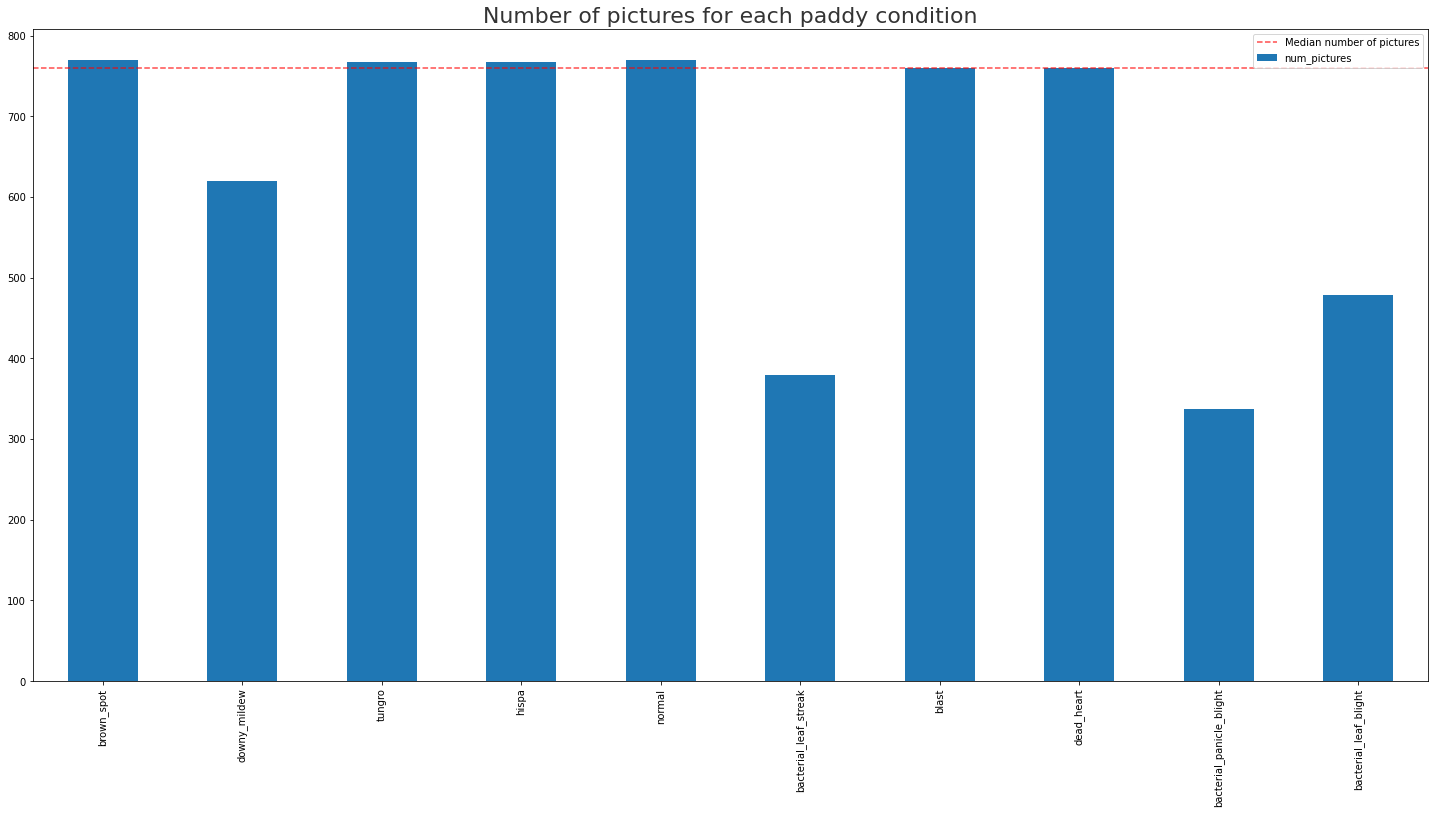

In [ ]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_disease.plot(kind="bar",
               legend=True,
               ax=ax,
                label="Number of pictures")
ax.axhline(df_disease["num_pictures"].median(),
           color='r', alpha=.7,
           linestyle='--',
           label="Median number of pictures")
plt.title("Number of pictures for each "\
          "paddy condition",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

In [9]:
df2 = df_meta.groupby('variety')['image_id'].nunique()

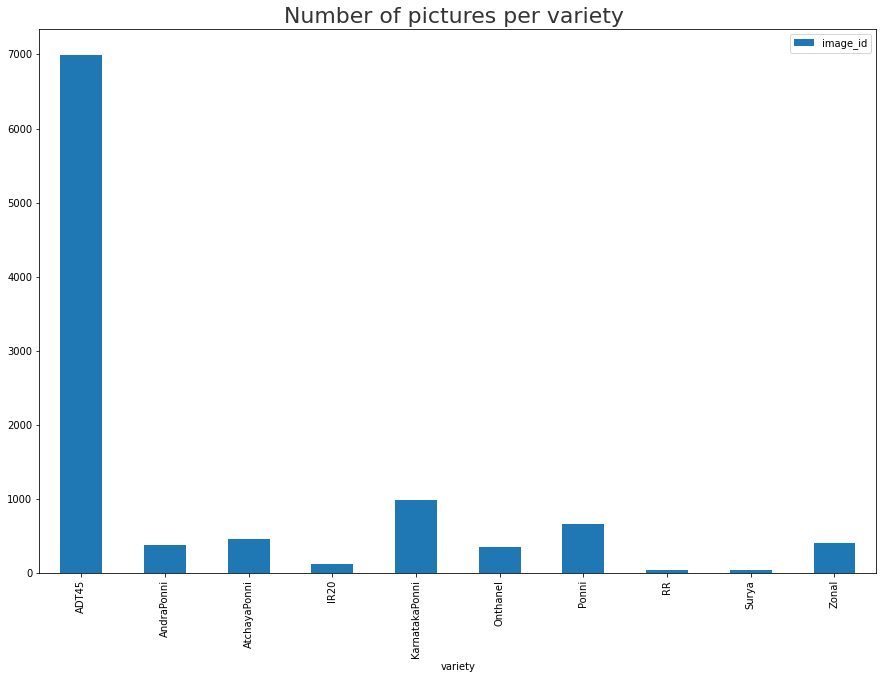

In [10]:
# number of images / variety
# Plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15,10))
df2.plot(kind="bar",
               legend=True,
               ax=ax)

plt.title("Number of pictures per variety ",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

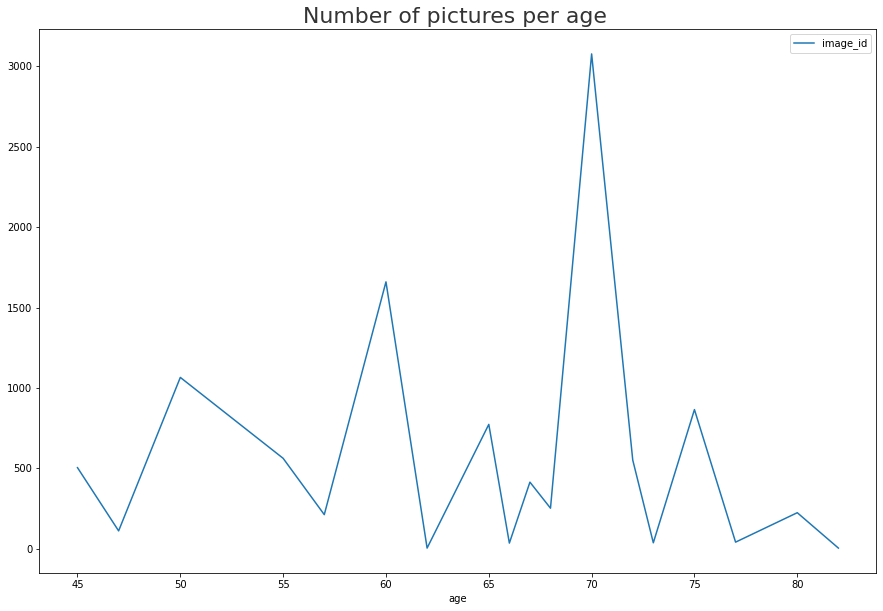

In [11]:
df3 = df_meta.groupby('age')['image_id'].nunique()
# Plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15,10))
df3.plot(kind="line",
               legend=True,
               ax=ax)

plt.title("Number of pictures per age ",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

In [ ]:
#visualisation of the different paddy conditions

def show_images_classes(path, classes, num_sample):

    fig = plt.figure(figsize=(20,20))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample//5+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

#read images
for i in range(0, len(disease_list)):
    show_images_classes(train_dir, disease_list[i], 5)


Output hidden; open in https://colab.research.google.com to view.

## ResNet152v2

### preprocessing

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds):
    def input_preprocess(image, label):
        label = tf.one_hot(label, n_classes)
        return image, label
    ds = ds.map(input_preprocess, num_parallel_calls = AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size = AUTOTUNE)
    return ds

In [ ]:
train_ds = prepare_dataset(train_data)
val_ds = prepare_dataset(valid_data)

In [16]:
img_width = 200
img_height = 200
batch_size = 32

epochs = 100
epochs_ft = 200

nb_classes = 10

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
    )

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    subset='training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

valid_generator = train_datagen.flow_from_directory(
    train_path,
    subset='validation',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 5131 images belonging to 10 classes.
Found 1280 images belonging to 10 classes.


In [ ]:
# images for prediction
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    classes=['.'],
    shuffle=False,)

Found 3469 images belonging to 1 classes.


In [17]:
#pour feature extraction
features_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
    )

features_generator = features_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=None,
    class_mode='categorical',
)

Found 6411 images belonging to 10 classes.


In [18]:
#f1_score from tensorflow_addons
f1_tfa = tfa.metrics.F1Score(num_classes=n_classes, average='macro')

In [19]:
def plot_history(dict_history, first_score, second_score):


  """
creates two subplots for plotting 2 different metrics
called first_score and second_score against epoch number,
values obtained from the train and the validation datasets
are visualized
  """

  with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))

        # first suplot
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('Pre-trained ResNet152v2 on Paddy dataset ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        # second subplot
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('Pre-trained ResNet152v2 on Paddy dataset ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

##Model building

In [ ]:
# Adds new top to base model
def add_top(base):
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)

    predictions = Dense(nb_classes, activation='softmax')(x)# Output layer

    return Model(inputs=base.input, outputs=predictions)

In [ ]:
#optimizer AdaBelief
opt = tfa.optimizers.AdaBelief(
    learning_rate=1e-3,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
    rectify=True,
)

In [ ]:
# Sets up model for transfer learning
def setup_model(model, base):

    for layer in base.layers:
        layer.trainable = False #freeze base layers

    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

In [ ]:
# Import the ResNet152v2 model to use as the base for our model
resnet_base = tf.keras.applications.ResNet152V2(
    input_shape=(img_width, img_height,3),
    include_top=False,
    weights="imagenet"
    )

model = add_top(resnet_base)
setup_model(model, resnet_base)

234561536/234545216 [==============================] - 2s 0us/step


#### Train new top layers

In [ ]:
# Train new top layers
model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    verbose=1,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
161/161 [==============================] - 98s 558ms/step - loss: 2.3944 - accuracy: 0.1495 - val_loss: 2.1151 - val_accuracy: 0.2266
Epoch 2/100
161/161 [==============================] - 85s 531ms/step - loss: 1.9701 - accuracy: 0.2982 - val_loss: 1.8068 - val_accuracy: 0.3633
Epoch 3/100
161/161 [==============================] - 86s 531ms/step - loss: 1.7330 - accuracy: 0.3970 - val_loss: 1.7270 - val_accuracy: 0.4172
Epoch 4/100
161/161 [==============================] - 86s 532ms/step - loss: 1.6219 - accuracy: 0.4407 - val_loss: 1.5964 - val_accuracy: 0.4445
Epoch 5/100
161/161 [==============================] - 85s 530ms/step - loss: 1.5698 - accuracy: 0.4537 - val_loss: 1.5500 - val_accuracy: 0.4859
Epoch 6/100
161/161 [==============================] - 85s 529ms/step - loss: 1.5192 - accuracy: 0.4769 - val_loss: 1.4875 - val_accuracy: 0.4906
Epoch 7/100
161/161 [==============================] - 85s 530ms/step - loss: 1.4398 - accuracy: 0.5020 - val_loss: 1.4251 -

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers")
print("the model is saved")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers/assets
the model is saved


In [ ]:
#load model
model = load_model("/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers")


#### Setup model for fine tuning

In [ ]:
# Setup model for fine tuning
def setup_model(model, trainable):
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False # freeze model base

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True # allow training layers

    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,  # Slow learning rate for fine-tuning
        metrics=['accuracy']
    )

In [ ]:
# Setup model to retrain our top layer plus 2 last blocks
setup_model(model, 26)

In [ ]:
# callbacks : early stopping
early_stp = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5)

In [ ]:
# Fine-tune the model
history4=model.fit(
    train_generator,
    epochs=epochs_ft,
    validation_data=valid_generator,
    verbose=1,
    callbacks=early_stp
)

Epoch 1/200
161/161 [==============================] - 99s 501ms/step - loss: 1.2660 - accuracy: 0.5794
Epoch 2/200
161/161 [==============================] - 81s 500ms/step - loss: 0.8178 - accuracy: 0.7252
Epoch 3/200
161/161 [==============================] - 80s 493ms/step - loss: 0.7119 - accuracy: 0.7652
Epoch 4/200
161/161 [==============================] - 80s 499ms/step - loss: 0.6287 - accuracy: 0.7872
Epoch 5/200
161/161 [==============================] - 80s 493ms/step - loss: 0.5926 - accuracy: 0.8014
Epoch 6/200
161/161 [==============================] - 81s 500ms/step - loss: 0.5698 - accuracy: 0.8162
Epoch 7/200
161/161 [==============================] - 80s 496ms/step - loss: 0.5418 - accuracy: 0.8258
Epoch 8/200
161/161 [==============================] - 79s 493ms/step - loss: 0.4896 - accuracy: 0.8406
Epoch 9/200
161/161 [==============================] - 81s 500ms/step - loss: 0.4540 - accuracy: 0.8480
Epoch 10/200
161/161 [==============================] - 80s 495m

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_fine_tuned_26")
print("the model is saved")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_fine_tuned_26/assets
the model is saved


In [ ]:
#predict sur test set avec resnet_26 layers
disease_pred = model.predict(
        test_generator,
        batch_size=32,
        )

In [ ]:
# formatting Kaggle submission
predicted_class_indices=np.argmax(disease_pred,axis=1)
print(set(predicted_class_indices))

inv_map = {v:k for k,v in train_generator.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


###feature extraction for future classification

In [ ]:
from tensorflow.keras.models import load_model

resnet = load_model('/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_fine_tuned')
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
#features as vector
from keras.models import Model
extractor = Model(inputs=resnet.inputs, outputs=resnet.get_layer('global_average_pooling2d').output)

In [ ]:
features = extractor.predict(features_generator)

In [ ]:
import numpy as np
np.save('/content/drive/MyDrive/Colab Notebooks/paddy/resnet_train_features.npy',
        features
        )

In [ ]:
features

array([[1.3958767e-01, 0.0000000e+00, 2.1052444e-01, ..., 2.5995275e-01,
        2.3295243e-01, 1.3605195e-01],
       [7.0347562e-02, 3.5302755e-01, 0.0000000e+00, ..., 2.6250997e-01,
        4.7581993e-02, 3.7727752e-04],
       [8.9329667e-02, 3.5451594e-01, 3.3279669e-01, ..., 7.8598255e-01,
        1.6052764e-02, 4.5336917e-01],
       ...,
       [2.3775879e-02, 3.5819954e-01, 0.0000000e+00, ..., 1.7842248e-01,
        4.0694055e-01, 6.0170345e-02],
       [4.6558119e-03, 1.3682973e-01, 2.5103068e-01, ..., 5.4945755e-01,
        1.1953112e-02, 0.0000000e+00],
       [2.0308977e-02, 3.9501261e-02, 5.2355796e-01, ..., 1.2693298e-01,
        0.0000000e+00, 2.0509057e-01]], dtype=float32)

In [ ]:
#get classes
x,y = features_generator.next()

In [ ]:
print(len(y))

6411


In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/paddy/target_train_paddy.npy',y)

#### images features + metadata in gbm classifier

In [ ]:
#concatenate features from images with metadata
df_feat = pd.DataFrame(features)

In [ ]:
df_feat.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.139588,0.000000,0.210524,0.000000,0.666899,0.664828,0.010476,0.019738,0.0,0.084990,...,1.403242,0.000000,0.105543,0.020411,0.155562,0.060386,1.471093,0.259953,0.232952,0.136052
1,0.070348,0.353028,0.000000,0.320150,0.576641,0.154265,0.387742,0.018312,0.0,0.523028,...,0.569842,0.000000,0.301794,0.000000,0.546042,0.026524,0.594858,0.262510,0.047582,0.000377
2,0.089330,0.354516,0.332797,1.304994,0.193011,0.128608,0.000000,0.000000,0.0,0.003377,...,0.000000,0.038477,0.018226,0.004933,0.710452,0.000000,0.594483,0.785983,0.016053,0.453369
3,0.063697,0.269420,0.175823,0.608938,0.070597,0.623174,0.012941,0.000000,0.0,0.000000,...,0.168628,0.341892,0.013262,0.013886,0.189130,0.009164,1.071386,0.314274,0.359584,0.816320
4,0.024662,0.198447,0.000000,0.077448,0.086731,0.003153,0.000355,0.022020,0.0,0.000821,...,0.321922,0.524812,0.126951,0.059856,0.052624,0.026230,0.191431,0.399338,0.072120,0.048504


In [ ]:
df_meta = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/paddy/train.csv")

In [ ]:
df_feat = df_feat.join(df_meta)

In [ ]:
df_feat.head()

,0,1,2,3,4,5,6,7,8,9,...,2042,2043,2044,2045,2046,2047,image_id,label,variety,age
0,0.139588,0.000000,0.210524,0.000000,0.666899,0.664828,0.010476,0.019738,0.0,0.084990,...,0.155562,0.060386,1.471093,0.259953,0.232952,0.136052,100330.jpg,bacterial_leaf_blight,ADT45,45
1,0.070348,0.353028,0.000000,0.320150,0.576641,0.154265,0.387742,0.018312,0.0,0.523028,...,0.546042,0.026524,0.594858,0.262510,0.047582,0.000377,100365.jpg,bacterial_leaf_blight,ADT45,45
2,0.089330,0.354516,0.332797,1.304994,0.193011,0.128608,0.000000,0.000000,0.0,0.003377,...,0.710452,0.000000,0.594483,0.785983,0.016053,0.453369,100382.jpg,bacterial_leaf_blight,ADT45,45
3,0.063697,0.269420,0.175823,0.608938,0.070597,0.623174,0.012941,0.000000,0.0,0.000000,...,0.189130,0.009164,1.071386,0.314274,0.359584,0.816320,100632.jpg,bacterial_leaf_blight,ADT45,45
4,0.024662,0.198447,0.000000,0.077448,0.086731,0.003153,0.000355,0.022020,0.0,0.000821,...,0.052624,0.026230,0.191431,0.399338,0.072120,0.048504,101918.jpg,bacterial_leaf_blight,ADT45,45


In [ ]:
#train test split sur features
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features,y, test_size = 0.25, random_state = 42)


In [ ]:
#reduce dimension with PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_std = scaler.transform(x_train)
x_std_test = scaler.transform(x_test)


In [ ]:
pca_res = PCA(n_components=0.99)
pca_res_train = pca_res.fit_transform(x_std)
pca_res_test = pca_res.transform(x_std_test)


In [ ]:
pca_res_train.shape

(4808, 1509)

### autres essais resnet

In [ ]:
# Fine-tune the model, retraining 10 layers
model.fit(
    train_generator,
#    steps_per_epoch=training_samples // batch_size,
    epochs=epochs_ft,
    validation_data=valid_generator,
#    validation_steps=testing_samples // batch_size,
    verbose=1,
    callbacks=early_stp
)

Epoch 1/200
161/161 [==============================] - 84s 522ms/step - loss: 0.6779 - accuracy: 0.7798 - val_loss: 0.8213 - val_accuracy: 0.7398
Epoch 2/200
161/161 [==============================] - 83s 517ms/step - loss: 0.6325 - accuracy: 0.7965 - val_loss: 0.7834 - val_accuracy: 0.7375
Epoch 3/200
161/161 [==============================] - 83s 518ms/step - loss: 0.5967 - accuracy: 0.8090 - val_loss: 0.7799 - val_accuracy: 0.7633
Epoch 4/200
161/161 [==============================] - 83s 518ms/step - loss: 0.5725 - accuracy: 0.8186 - val_loss: 0.7403 - val_accuracy: 0.7484
Epoch 5/200
161/161 [==============================] - 83s 517ms/step - loss: 0.5629 - accuracy: 0.8219 - val_loss: 0.7372 - val_accuracy: 0.7758
Epoch 6/200
161/161 [==============================] - 83s 518ms/step - loss: 0.5484 - accuracy: 0.8291 - val_loss: 0.7103 - val_accuracy: 0.7734
Epoch 7/200
161/161 [==============================] - 83s 516ms/step - loss: 0.5539 - accuracy: 0.8176 - val_loss: 0.7251 -

In [ ]:


lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.8, min_lr = 1e-6)

mcp = ModelCheckpoint('ResNet152V2.h5')

es = EarlyStopping(verbose=1, patience=2)



In [ ]:
model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics="accuracy")

In [ ]:
history2 = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=100,callbacks=[lrd,mcp,es])

Epoch 1/100
160/160 [==============================] - 96s 555ms/step - loss: 1.1264 - accuracy: 0.6215 - val_loss: 2.0581 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 2/100
160/160 [==============================] - 86s 535ms/step - loss: 0.8764 - accuracy: 0.7023 - val_loss: 1.0593 - val_accuracy: 0.6516 - lr: 0.0010
Epoch 3/100
160/160 [==============================] - 86s 540ms/step - loss: 0.7661 - accuracy: 0.7392 - val_loss: 1.1541 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 4/100
160/160 [==============================] - 87s 543ms/step - loss: 0.7039 - accuracy: 0.7637 - val_loss: 0.9551 - val_accuracy: 0.6789 - lr: 0.0010
Epoch 5/100
160/160 [==============================] - 86s 540ms/step - loss: 0.6597 - accuracy: 0.7813 - val_loss: 0.9715 - val_accuracy: 0.6930 - lr: 0.0010
Epoch 6/100
160/160 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.7898
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
160/160 [========================

In [ ]:
base_model=model

In [ ]:
#freezing base layers
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10,activation='softmax'))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.8, min_lr = 1e-6)

mcp = ModelCheckpoint('ResNet152V2.h5')

es = EarlyStopping(verbose=1, patience=5)

In [ ]:
opt = tfa.optimizers.AdaBelief(
    learning_rate=1e-3,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
    rectify=True,
)

In [ ]:
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy', f1_tfa])

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size



In [ ]:
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

160
40


In [ ]:
%time
history3 = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=100,
                    callbacks=[lrd,mcp,es])



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Epoch 1/100
160/160 [==============================] - 103s 547ms/step - loss: 2.6737 - accuracy: 0.0965 - f1_score: 0.1693 - val_loss: 2.2408 - val_accuracy: 0.1305 - val_f1_score: 0.1046 - lr: 0.0010
Epoch 2/100
160/160 [==============================] - 85s 530ms/step - loss: 2.3848 - accuracy: 0.1565 - f1_score: 0.1380 - val_loss: 1.8506 - val_accuracy: 0.6594 - val_f1_score: 0.6613 - lr: 0.0010
Epoch 3/100
160/160 [==============================] - 84s 528ms/step - loss: 2.0144 - accuracy: 0.3059 - f1_score: 0.2891 - val_loss: 1.3638 - val_accuracy: 0.7453 - val_f1_score: 0.7514 - lr: 0.0010
Epoch 4/100
160/160 [==============================] - 84s 528ms/step - loss: 1.8153 - accuracy: 0.4001 - f1_score: 0.3977 - val_loss: 1.2993 - val_accuracy: 0.6844 - val_f1_score: 0.6901 - lr: 0.0010
Epoch 5/100
160/160 [==============================] - 85s 529ms/step - loss: 1.8116 - accuracy: 0.4118 - f1_score: 0.4186 - val_lo

##Xception

### Preprocessing

In [ ]:
# preprocessing with data augmentation for train set (train + validation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input
    )

In [ ]:
# preprocessing without data augmentation for test set
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

###Model building

In [ ]:
# Adds new top to base model
def add_top(base):
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)

    predictions = Dense(nb_classes, activation='softmax')(x)# Output layer

    return Model(inputs=base.input, outputs=predictions)

In [ ]:
#optimizer AdaBelief
opt = tfa.optimizers.AdaBelief(
    learning_rate=1e-3,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
    rectify=True,
)

In [ ]:
# Sets up model for transfer learning
def setup_model(model, base):

    for layer in base.layers:
        layer.trainable = False #freeze base layers

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

In [ ]:
# Import the Xception model to use as the base for our model
xception_base = xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width, img_height, 3)
)

model = add_top(xception_base)
setup_model(model, xception_base)

In [ ]:
# Train new top layers
model.fit_generator(
    train_generator,
#    steps_per_epoch=training_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
#    validation_steps=testing_samples // batch_size,
    verbose=1,
)

In [ ]:
# Setup model for fine tuning
def setup_model(model, trainable):
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False # freeze model base

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True # allow training layers

    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,  # Slow learning rate for fine-tuning
        metrics=['accuracy']
    )

In [ ]:
# Setup model to retrain our top layer plus block 13 and 14 of Xception
setup_model(model, 19)

In [ ]:
# callbacks : early stopping
early_stp = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5)

In [ ]:
# Fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=training_samples // batch_size,
    epochs=epochs_ft,
    validation_data=test_generator,
    validation_steps=testing_samples // batch_size,
    verbose=1,
    callbacks=early_stp
)

### model_builder for keras_tuner



In [ ]:
for layer in xception_model.layers:
    layer.trainable = False

In [ ]:
def model_builder(hp):

  model = tf.keras.Sequential()
  Xception_plot = tf.keras.utils.plot_model(xception_model,
                                          to_file='xception_plot.png',
                                          show_shapes=True,
                                          show_layer_names=False)
  
  for layer in xception_model.layers:
    layer.trainable = False

  base_output = xception_model.output
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  base_output = Dense(units=hp_units, activation='relu')(base_output)
  base_output = Dropout(0.2)(base_output)

  predictions = Dense(num_disease, activation='softmax')(base_output)

  model = Model(inputs=xception_model.input,
                          outputs=predictions)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                          loss="categorical_crossentropy",
                          metrics=['accuracy', f1_tfa])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

In [ ]:
# callbacks : early stopping
early_stp = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

In [ ]:
tuner.search(
    train_datagen.flow(
        x_train, y_train,
        batch_size=32,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=8,
        subset='validation'),
    epochs=10,
    callbacks=[early_stp]
)

Trial 10 Complete [00h 21m 49s]
val_accuracy: 0.2620904743671417

Best val_accuracy So Far: 0.2815912663936615
Total elapsed time: 03h 44m 39s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
320               |384               |units
0.001             |0.01              |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
161/161 [==============================] - ETA: 0s - loss: 1.8995 - accuracy: 0.2410 - f1_score: 0.1175

KeyboardInterrupt: ignored

In [ ]:
opt = tfa.optimizers.AdaBelief(
    learning_rate=1e-3,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
    rectify=True,
)

In [ ]:
#avec Adabelief
def model_builder(hp):

  model = tf.keras.Sequential()
  Xception_plot = tf.keras.utils.plot_model(xception_model,
                                          to_file='xception_plot.png',
                                          show_shapes=True,
                                          show_layer_names=False)
  
  for layer in xception_model.layers:
    layer.trainable = False

  base_output = xception_model.output
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  base_output = Dense(units=512, activation='relu')(base_output)
  base_output = Dropout(0.2)(base_output)

  predictions = Dense(num_disease, activation='softmax')(base_output)

  model = Model(inputs=xception_model.input,
                outputs=predictions)

  #hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


  model.compile(optimizer=opt,
                loss="categorical_crossentropy",
                metrics=['accuracy', f1_tfa])

  return model

In [ ]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

In [ ]:
tuner.search(
    train_datagen.flow(
        x_train, y_train,
        batch_size=32,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=8,
        subset='validation'),
    epochs=10,
    callbacks=[early_stp])

Trial 18 Complete [00h 30m 01s]
val_accuracy: 0.2761310338973999

Best val_accuracy So Far: 0.2925117015838623
Total elapsed time: 03h 43m 23s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
352               |128               |units
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/4
161/161 [==============================] - 301s 2s/step - loss: 1.9046 - accuracy: 0.2591 - f1_score: 0.0945 - val_loss: 1.8629 - val_accuracy: 0.2559 - val_f1_score: 0.0730
Epoch 2/4
161/161 [==============================] - ETA: 0s - loss: 1.8437 - accuracy: 0.2759 - f1_score: 0.0985

KeyboardInterrupt: ignored